# Simulating LiteBIRD-like TODs with beamconv

This demo wants to show the ...

### Preliminary steps
First, we import all the modules and libraries that we need. In particular:
- beamconv (<a href="https://github.com/AdriJD/beamconv">github.com/AdriJD/beamconv</a>);
- qpoint (<a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">gitlab.mpcdf.mpg.de/mtr/ducc</a>);
- ducc0 (<a href="https://github.com/arahlin/qpoint">github.com/arahlin/qpoint</a>).

The last lines are there for aestethic purposes only.

In [1]:
# Importing modules and libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from beamconv import ScanStrategy
import qpoint as qp

import ducc0

# Redefining color-maps
import copy
cmap_viridis = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap_magma = copy.copy(matplotlib.cm.get_cmap("magma"))

# Ignoring warnings (matplotlib)
import warnings
warnings.filterwarnings("ignore")

# For plots
import cycler

The Cls coefficients are read from an input file. Healpy evaluates the T, Q and U maps, which are then plotted.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


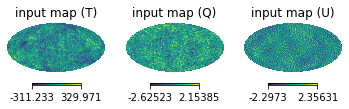

In [2]:
# Reading cls from .txt file
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',unpack=True)
ell, cls = cls[0], cls[1:]

# Calculating alm from cls and then producing map0
lmax=128
np.random.seed(25)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True)

#alm[0,hp.sphtfunc.Alm.getidx(lmax,1,0)] = 5.124              # Adding the static dipole (a_10)
#alm[0,hp.sphtfunc.Alm.getidx(lmax,1,1)] = (0.3384 - 3.215j)  # Adding the static dipole (a_11)

map0 = hp.alm2map(alm, lmax)

# Plots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map0[0],title='input map (T)', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map0[1],title='input map (Q)', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map0[2],title='input map (U)', hold=True, cmap=cmap_viridis)
plt.show()

Together with the <font color="SeaGreen">input maps</font>, we need to specify the <font color="SeaGreen">scanning strategy</font> and the <font color="SeaGreen">focal plane specifics</font>. Provided with that, beamconv is able to produce the TODs. 

### Scanning strategy
Here I define two <code>ScanStrategy</code> objects: one with and one without HWP.

In [3]:
# Setting up the scanning strategy parameters
ctime0 = 1510000000            # Initial time
mlen = 1 * 24 * 60 * 60        # Mission length in seconds (one day!)

# Definition of the scannin strategy making use of LiteBIRD's specifics (without HWP)
ss = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,
        theta_boresight = 50.,
        freq_antisun = 192.348, 
        freq_boresight = 0.314, 
        sample_rate = 19.1,
        jitter_amp=0.0,
        ctime0=ctime0)

# Definition of the scannin strategy making use of LiteBIRD's specifics (with HWP)
ss_hwp = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,
        theta_boresight = 50.,
        freq_antisun = 192.348, 
        freq_boresight = 0.314, 
        sample_rate = 19.1,
        jitter_amp=0.0,
        ctime0=ctime0)

In order to generate a LiteBIRD-like scanning strategy, some functionalities of pyScan (<a href="https://github.com/tmatsumu/LB_SYSPL_updated">github.com/tmatsumu/LB_SYSPL_updated</a>) have been implemented in beamconv. In particular
- The <code>litebird_scan</code> function returns a quaternion that determines the boresight orientation (\theta, \phi and \psi angle) at any time sample;
- <code>litebird_ctime</code>, instead, produces unix time (<code>ctime</code>) for a given chunk.

In [4]:
# Further options (without HWP)
scan_opts = dict(
        q_bore_func=ss.litebird_scan,
        ctime_func=ss.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True)

# Further options (with HWP)
scan_opts_hwp = dict(
        q_bore_func=ss_hwp.litebird_scan,
        ctime_func=ss_hwp.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True)

### Focal plane specifics
So far the two <code>ScanStrategy</code> objects (with and without HWP) are exactly identical. We can specify the HWP features when defining the beam and creating the focal plane. In particular, the Mueller matrix can be set up in in beam options, while the HWP frequency can be specified with <code>set_hwp_mode</code>. Here I'm using 4 detectors, with polarization angles 0, 90, 45 and 135 deg.

In [5]:
# Create a grid of Gaussian beams
ndet = 4
azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.array([[0,0],[90,90],[45,45],[135,135]])
deads = np.array ([[1,0],[1,0],[1,0],[1,0]])

# Setting up the beam options
beam_opts = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=40)          # Gaussian co-pol beam, so only specify FWHM (arcmin)

# Setting up the beam options
beam_opts_hwp = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=40,          # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 hwp_mueller=np.diag([1, 1, -1, -1]))

# Defining HWP frequency
ss_hwp.set_hwp_mod(mode='continuous', freq=88/60)

# Creating the focal planes (with and without HWP)
ss.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts)
ss_hwp.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts_hwp)

Last thing to set up is the partition of the mission in chunks.

In [6]:
# Calculate TODs in 10 chunks
nchunk = 10
nsamp_chunk = int(ss.mlen * ss.fsamp / nchunk)
nsamp = int(ss.mlen * ss.fsamp)

chunks = ss.partition_mission(nsamp_chunk)
chunks_hwp = ss_hwp.partition_mission(nsamp_chunk)

### Coverage maps
As a countercheck, let us produce the coverage maps.

In [7]:
# Producing the coverage map
ss.allocate_maps(nside=128)
ss.scan_instrument_mpi(alm, **scan_opts)
maps, cond, proj = ss.solve_for_map(return_proj = True)

ss_hwp.allocate_maps(nside=128)
ss_hwp.scan_instrument_mpi(alm, **scan_opts_hwp)
maps_hwp, cond, proj_hwp = ss_hwp.solve_for_map(return_proj = True)

Scanning with 8 detectors
[rank 000]: working on: det0, det0
[rank 000]:	Working on chunk 000: samples 0-165024
Implementing litebird scan
[rank 000]:	Working on chunk 001: samples 165024-330048
Implementing litebird scan
[rank 000]:	Working on chunk 002: samples 330048-495072
Implementing litebird scan
[rank 000]:	Working on chunk 003: samples 495072-660096
Implementing litebird scan
[rank 000]:	Working on chunk 004: samples 660096-825120
Implementing litebird scan
[rank 000]:	Working on chunk 005: samples 825120-990144
Implementing litebird scan
[rank 000]:	Working on chunk 006: samples 990144-1155168
Implementing litebird scan
[rank 000]:	Working on chunk 007: samples 1155168-1320192
Implementing litebird scan
[rank 000]:	Working on chunk 008: samples 1320192-1485216
Implementing litebird scan
[rank 000]:	Working on chunk 009: samples 1485216-1650240
Implementing litebird scan
[rank 000]: working on: det1, det1
[rank 000]:	Working on chunk 000: samples 0-165024
Implementing litebird

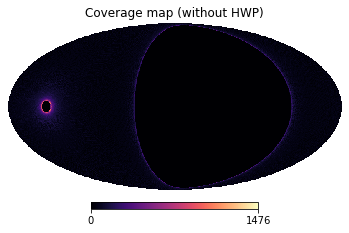

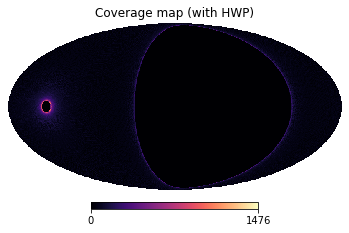

In [8]:
hp.mollview(proj[0],title='Coverage map (without HWP)', hold=True, cmap=cmap_magma)
plt.show()

hp.mollview(proj_hwp[0],title='Coverage map (with HWP)', hold=True, cmap=cmap_magma)
plt.show()

### Injecting noise
By making use of <code>ducc0</code> we can produce a noise realization, given its power spectrum in frequency.

In [9]:
# Parameters for generating noise with ducc0 P(f)=sigma^2(1/fsamp)^2[(f^2+fknee^2)/(f^2+fmin^2)]^(alpha/2)
sigma = 10
f_min = 1e-4
f_knee = 1e-1
f_samp = 19.1
slope = -1.7

The clean TODs are produced by beamconv for each chunk, for both missions (with and without HWP). The same noise is added to the two missions, obtaining two sets of noisy TODs.

In [10]:
# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD = np.empty((ndet,nsamp))
noisy_TOD = np.empty((ndet,nsamp))
noise_TOD = np.empty((ndet,nsamp))

# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD_hwp = np.empty((ndet,nsamp))
noisy_TOD_hwp = np.empty((ndet,nsamp))
noise_TOD_hwp = np.empty((ndet,nsamp))

for det in np.arange(ndet):
    gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
    for chunk in np.arange(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        noise = gen.filterGaussian(inp)
        #
        clean_data = ss.data(chunks[chunk],ss.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = clean_data
        noisy_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noisy_data
        noise_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noise
        #
        clean_data = ss_hwp.data(chunks_hwp[chunk],ss_hwp.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = clean_data
        noisy_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noisy_data
        noise_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noise

As a countercheck, we can plot the noise power spectrum. Also, we can see how the HWP affects the TODs.

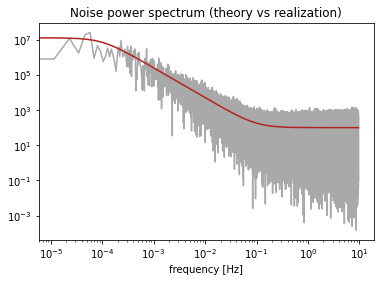

In [11]:
# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,:]))**2 / nsamp
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs realization)')
plt.xlabel('frequency [Hz]')
plt.show()

[...]

In [12]:
noise = np.zeros(nsamp)
ps = np.zeros(nsamp)
nps = int(300)

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)

for i in np.arange(nps):
    for chunk in np.arange(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        #
        noise[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] += gen.filterGaussian(inp)
    ps += np.abs(np.fft.fft(noise))**2 / nsamp

ps = ps/nps

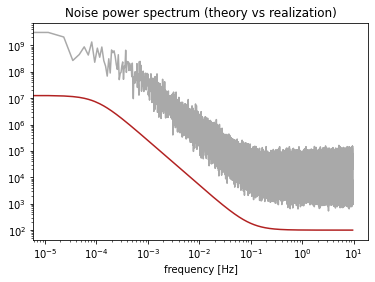

In [13]:
# Plotting the power spectrum
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs realization)')
plt.xlabel('frequency [Hz]')
plt.show()

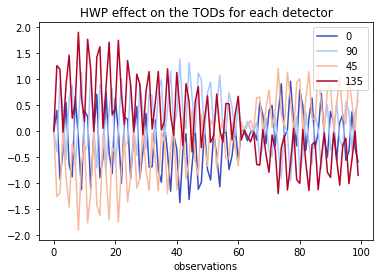

In [14]:
# How the TODs are affected by the presence of the HWP
n = 4
color = plt.cm.coolwarm(np.linspace(0,1,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

plt.plot(clean_TOD[0][:100]-clean_TOD_hwp[0][:100],label='0')
plt.plot(clean_TOD[1][:100]-clean_TOD_hwp[1][:100],label='90')
plt.plot(clean_TOD[2][:100]-clean_TOD_hwp[2][:100],label='45')
plt.plot(clean_TOD[3][:100]-clean_TOD_hwp[3][:100],label='135')
plt.title('HWP effect on the TODs for each detector')
plt.legend(loc=1)
plt.xlabel('observations')
plt.show()

- The difference (TOD with HWP - TOD without HWP) is of the right order of magnitude, since the HWP only affects the Q and U contributions to the signal, whose absolute values is smaller than &sim;2;
- Detectors sensitive to orthogonal polarization directions have opposite (TOD with HWP - TOD without HWP) values.

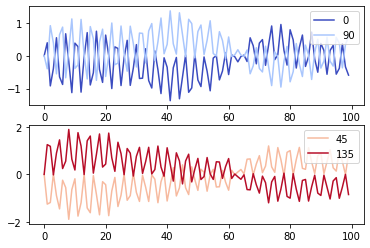

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

plt.axes(ax1)
ax1.plot(clean_TOD[0][:100]-clean_TOD_hwp[0][:100],label='0',color=plt.cm.coolwarm(0))
ax1.plot(clean_TOD[1][:100]-clean_TOD_hwp[1][:100],label='90',color=plt.cm.coolwarm(0.33))
ax1.legend(loc=1)

plt.axes(ax2)
ax2.plot(clean_TOD[2][:100]-clean_TOD_hwp[2][:100],label='45',color=plt.cm.coolwarm(0.66))
ax2.plot(clean_TOD[3][:100]-clean_TOD_hwp[3][:100],label='135',color=plt.cm.coolwarm(0.99))
ax2.legend(loc=1)

plt.show()

### Noisy TODs (with and without HWP)
[...]

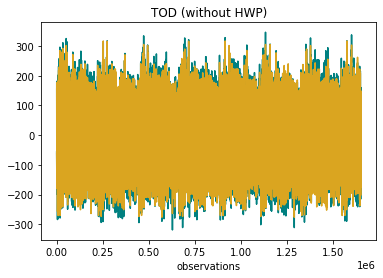

In [16]:
prec_idx = int(3.2058 * 60 * 60)
plt.plot(noisy_TOD[0,:],'teal')
plt.plot(clean_TOD[0,:],'goldenrod')
plt.title('TOD (without HWP)')
plt.xlabel('observations')
plt.show()

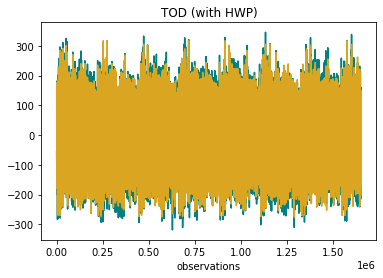

In [17]:
plt.plot(noisy_TOD_hwp[0,:],'teal')
plt.plot(clean_TOD_hwp[0,:],'goldenrod')
plt.title('TOD (with HWP)')
plt.xlabel('observations')
plt.show()

## Things to do next
- 
- 
- 
- 

In [18]:
hwp_freq = ss_hwp.hwp_dict['freq']
fd_without = np.fft.rfft(clean_TOD[1])
fd_with = np.fft.rfft(clean_TOD_hwp[1])
freqs = np.fft.rfftfreq(clean_TOD[1].size, d=1/ss.fsamp)
psd_without = np.abs(fd_without) ** 2
psd_with = np.abs(fd_with) ** 2

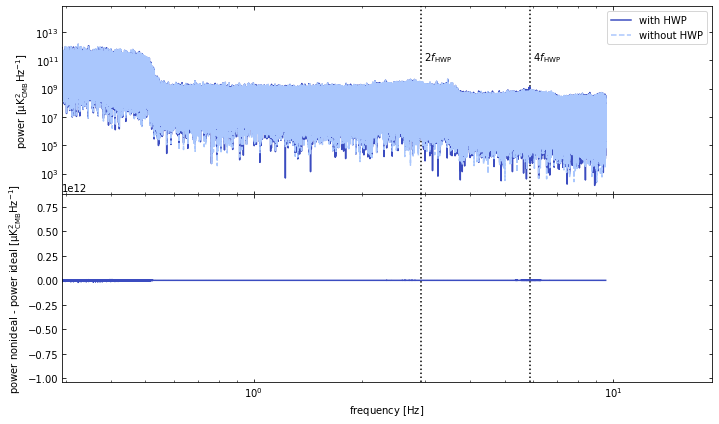

In [19]:
fig, axs = plt.subplots(nrows=2, figsize=(nchunk,6), sharex=True)
for ax in axs.ravel():
    ax.axvline(4 * hwp_freq, color='black', linestyle=':')
    ax.axvline(2 * hwp_freq, color='black', linestyle=':')
    ax.tick_params(direction='in', right=True, top=True, which='both')

axs[0].set_ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')
axs[0].plot(freqs, psd_with, label='with HWP')
axs[0].plot(freqs, psd_without, label='without HWP', ls='--')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].annotate(r' $2f_{\mathrm{HWP}}$', (2 * hwp_freq , 1e11),
               xycoords='data')
axs[0].annotate(r' $4f_{\mathrm{HWP}}$', (4 * hwp_freq , 1e11),
               xycoords='data')

axs[1].set_ylabel('power nonideal - power ideal [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')
axs[1].plot(freqs, psd_with - psd_without)
axs[1].set_xscale('log')
axs[1].set_xlim(0.2 * hwp_freq)

axs[1].set_xlabel('frequency [$\mathrm{Hz}$]')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show(fig)

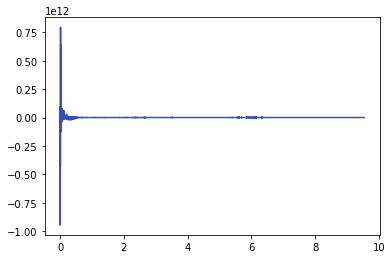

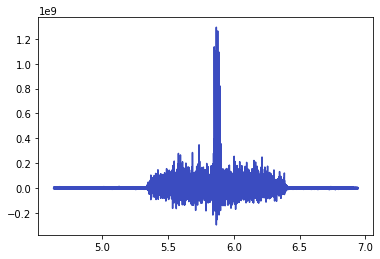

In [20]:
plt.plot(freqs, psd_with - psd_without)
plt.show()

plt.plot(freqs[400000:600000], psd_with[400000:600000] - psd_without[400000:600000])
plt.show()